In [1]:
from sklearn.metrics import r2_score
from scipy.integrate import tplquad, quad
import healpy as hp
import numpy as np
import quaternionic
import spherical
import os
import numgrid
def sign(n):
    if n >= 0:
        return 1;
    return -1;

def d(wigner_obj, l, m, k, theta):
    return wigner_obj.dlmk(np.exp(1j * theta))[wigner_obj.dindex(l,m,k)]

def Phi(m, x):
    if m > 0:
        return np.sqrt(2)*np.cos(m*x)
    elif m < 0:
        return np.sqrt(2)*np.sin(np.abs(m)*x)
    return 1

def RealD(wigner_obj, phi, theta, chi):
    ind = 0;
    𝔇 = np.zeros(wigner_obj.Dsize);
    for el in range(wigner_obj.ell_max+1):
        for m in np.arange(-el, el+1):
            for k in np.arange(-el, el+1):
                𝔇[ind] += sign(k)*Phi(m,phi)*Phi(k,chi) * 0.5 * \
                    (d(wigner,el,abs(k),abs(m),theta) + np.power(-1.0,m)*d(wigner,el,abs(m),-abs(k),theta)) -\
                    sign(m)*Phi(-m,phi)*Phi(-k,chi) * 0.5 * \
                    (d(wigner,el,abs(k),abs(m),theta) - np.power(-1.0,m)*d(wigner,el,abs(m),-abs(k),theta))
                ind += 1;
    return 𝔇;
    
    

In [2]:
# Define system / get directory
system = 'healpix-meth';
nside = 2;    # subject to variation

cwd = os.getcwd();
sysdir = os.path.join(cwd, system)
print(sysdir)

/Users/lancebettinson/Thesis/umrr/code/spherical_schrodinger/notebooks/healpix-meth


In [3]:
# Obtain data at sampling points
pts = np.load(os.path.join(sysdir,'xsph.npy'));
vpts = np.load(os.path.join(sysdir,'v.npy'));
assert len(pts) == len(vpts);
# print(vpts)

In [11]:
LMAX = 0;
converged = False;
Lmax_array = [];
R2_array = [];
R2r_array = [];
while not converged:    
    # spherical.wigner implementation
    # Build a matrix of Wigner D matrix elements
    Dbasis = []
    𝔇rbasis = []
    for pt,v in zip(pts,vpts):
        R = quaternionic.array.from_euler_angles(pt[1], pt[0], pt[2])
        wigner = spherical.Wigner(LMAX);
        #D = wigner.D(R).conjugate();
        D = wigner.D(R);
        #𝔇r = RealD(wigner, pt[1], pt[0], pt[2]);
        Dbasis.append(D);
        #𝔇rbasis.append(𝔇r);
    Dbasis = np.array(Dbasis);
    #𝔇rbasis = np.array(𝔇rbasis)
    #print(Dbasis.shape)
    U,S,V = np.linalg.svd(Dbasis, full_matrices=False)
    #Ur,Sr,Vr = np.linalg.svd(𝔇rbasis, full_matrices=False)
    ahat = np.matmul( np.linalg.pinv(np.matmul(U, np.matmul( np.diag(S), V))), np.array(vpts))
    #ar = np.matmul( np.linalg.pinv(np.matmul(Ur, np.matmul (np.diag(Sr), Vr))), np.array(vpts))
    
    # MAKE REAL BY UNITARY OPERATION
    #for a in ahat:
    #     print(a * np.exp(-1j * np.arctan(np.imag(a)/np.real(a))), '\t',
    #          a * np.exp(-1j * np.arctan2(np.imag(a),np.real(a))))
    #print(np.real(ahat * np.exp(-1j * np.arctan(np.imag(ahat)/np.real(ahat)))))
    
    # Check the fit
    predicted = np.zeros(len(vpts), dtype=np.complex128);
    predictedr = np.zeros(len(vpts))
    for i,pt in enumerate(pts):
        #R = quaternionic.array.from_euler_angles(*pt);
        R = quaternionic.array.from_euler_angles(pt[1], pt[0], pt[2]);
        wigner = spherical.Wigner(LMAX);
        #D = wigner.D(R).conjugate();
        D = wigner.D(R);
        #𝔇r = RealD(wigner, pt[1], pt[0], pt[2]);
        predicted[i] += np.dot(ahat, D);
        #predictedr[i] += np.dot(ar, 𝔇r);
    Lmax_array.append(LMAX);
    R2_array.append(r2_score(vpts, np.real(predicted)))
    #R2r_array.append(r2_score(vpts, predictedr))
    if np.abs(R2_array[-1] - 1) < 1e-3:
        converged = True;
        print("Converged at LMAX = {}".format(LMAX))
        print(r2_score(vpts, np.real(predicted)))
        break;
    LMAX += 1;
    #print(R2_array[-1], R2r_array[-1])
    print(r2_score(vpts, np.real(predicted)))
    
V = lambda phi,theta,chi: np.real(np.dot(ahat, spherical.Wigner(LMAX).D(quaternionic.array.from_euler_angles(phi,theta,chi))))

0.0
0.0030302730867073358
0.021709076693124607
0.7360638571247902
0.9166810877915823
0.9488801815399375
0.9897509622212916
Converged at LMAX = 7
0.9990988486318294


In [15]:
#print(np.linalg.norm(ahat), np.linalg.norm(ar))
for a in ahat:
    #print(np.real(a * np.exp(-1j * np.arctan2(np.imag(a), np.real(a)))))
    print(a)
    #print(np.around(np.real(a),6), '\t+', np.around(np.imag(a),6), 'i')

(0.005752074827363987+1.1855015850761573e-19j)
(-1.564892721383115e-05+1.8849851334175673e-05j)
(4.114074428839045e-05+1.8533159113267975e-05j)
(-9.391520800684556e-06+4.727405272329316e-05j)
(0.0002726824409753468+0.0002559013540872965j)
(-0.00017154158056848382+4.914097711072456e-19j)
(-0.00027268244097534413+0.0002559013540872953j)
(-9.391520800684627e-06-4.727405272329286e-05j)
(-4.114074428839086e-05+1.8533159113266847e-05j)
(-1.5648927213831806e-05-1.88498513341769e-05j)
(-1.11389800167253e-05-2.0152118314024664e-05j)
(1.3425917008415907e-05+1.9288647872083634e-05j)
(1.3189953443132201e-06-2.352344735584363e-05j)
(2.1512455861974698e-05-3.481988022491159e-05j)
(-4.790725054383386e-05+1.737126882135896e-05j)
(1.2426834689902378e-05-7.1850370615888195e-06j)
(-1.5282131938965155e-05+2.529062961799317e-05j)
(3.9680655433437064e-05-5.628088940789971e-05j)
(1.648535427011386e-05-2.1865432924159166e-05j)
(2.7117624813933717e-05-2.805154168682179e-06j)
(0.0001902141486365078-0.0003033369

In [6]:
#. Analytical solution to SO3FT coefficients

-0.7071067811865476


10

In [16]:
ind = np.arange(0,10)
count = 0
for l in np.arange(0,8):
    for m in np.arange(-l,l+1):
        for k in np.arange(-l,l+1):
            count += 1
            #print(wigner.Dindex(l,m,k))
print(count)

680


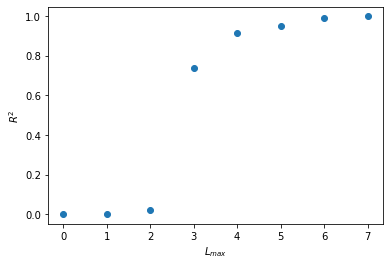

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('$R^2$')
ax.set_xlabel('$L_{max}$')
ax.scatter(Lmax_array,R2_array,marker='o')
#ax.scatter(Lmax_array,R2r_array,marker='x')


In [134]:
for pt,v in zip(pts,vpts):
    print(*pt, '\t\t\t', v, V(pt[1],pt[0],pt[2]))

0.4111378623223478 0.7853981633974483 0.0 			 0.0 2.8189256484623115e-17
0.4111378623223478 0.7853981633974483 0.5235987755982988 			 0.001564239999424899 0.001564239999425144
0.4111378623223478 0.7853981633974483 1.0471975511965976 			 0.0022551500023837434 0.0022551500023837447
0.4111378623223478 0.7853981633974483 1.5707963267948966 			 0.0038429000014730264 0.003842900001473016
0.4111378623223478 0.7853981633974483 2.0943951023931953 			 0.0035356700009288033 0.0035356700009288324
0.4111378623223478 0.7853981633974483 2.617993877991494 			 0.001590240000950871 0.0015902400009508782
0.4111378623223478 0.7853981633974483 3.141592653589793 			 0.0007134900006349199 0.0007134900006348726
0.4111378623223478 0.7853981633974483 3.665191429188092 			 0.001541969999379944 0.0015419699993800304
0.4111378623223478 0.7853981633974483 4.1887902047863905 			 0.0015717799997219117 0.0015717799997219198
0.4111378623223478 0.7853981633974483 4.71238898038469 			 0.0009372999993502162 0.000937299999

1.2309594173407747 3.926990816987241 3.141592653589793 			 0.006114260000686045 0.0061142600006860795
1.2309594173407747 3.926990816987241 3.665191429188092 			 0.019087430000581662 0.019087430000581655
1.2309594173407747 3.926990816987241 4.1887902047863905 			 0.008102110001345864 0.008102110001345841
1.2309594173407747 3.926990816987241 4.71238898038469 			 0.001082979999409872 0.0010829799994098851
1.2309594173407747 3.926990816987241 5.235987755982988 			 0.009143479999693227 0.009143479999693255
1.2309594173407747 3.926990816987241 5.759586531581287 			 0.018090960000336054 0.018090960000336064
1.2309594173407747 4.71238898038469 0.0 			 0.005341969999790308 0.005341969999790323
1.2309594173407747 4.71238898038469 0.5235987755982988 			 0.0012882000009994954 0.0012882000009994694
1.2309594173407747 4.71238898038469 1.0471975511965976 			 0.007902900000772206 0.00790290000077225
1.2309594173407747 4.71238898038469 1.5707963267948966 			 0.014928489999874728 0.014928489999874707
1.

1.9106332362490186 5.497787143782138 4.1887902047863905 			 0.0034256199996889336 0.0034256199996888607
1.9106332362490186 5.497787143782138 4.71238898038469 			 0.002112160000251606 0.0021121600002515766
1.9106332362490186 5.497787143782138 5.235987755982988 			 0.0074165000005450565 0.007416500000545095
1.9106332362490186 5.497787143782138 5.759586531581287 			 0.00915698000244447 0.009156980002444474
2.300523983021863 0.39269908169872414 0.0 			 0.001659620002101292 0.0016596200021013214
2.300523983021863 0.39269908169872414 0.5235987755982988 			 0.0028851400002167793 0.002885140000216802
2.300523983021863 0.39269908169872414 1.0471975511965976 			 0.005066480000095908 0.0050664800000959
2.300523983021863 0.39269908169872414 1.5707963267948966 			 0.006152100000690552 0.006152100000690554
2.300523983021863 0.39269908169872414 2.0943951023931953 			 0.0046573899999202695 0.0046573899999203024
2.300523983021863 0.39269908169872414 2.617993877991494 			 0.0025243899999622954 0.0025243

2.300523983021863 5.105088062083414 3.665191429188092 			 0.0019549300013750326 0.0019549300013750256
2.300523983021863 5.105088062083414 4.1887902047863905 			 0.0017316300018137554 0.0017316300018137248
2.300523983021863 5.105088062083414 4.71238898038469 			 0.001494000000093365 0.001494000000093337
2.300523983021863 5.105088062083414 5.235987755982988 			 0.002011390002735425 0.0020113900027353845
2.300523983021863 5.105088062083414 5.759586531581287 			 0.0018245200008095708 0.0018245200008095799
2.300523983021863 5.890486225480861 0.0 			 0.002287389999764855 0.0022873899997648823
2.300523983021863 5.890486225480861 0.5235987755982988 			 0.002669110001079389 0.002669110001079371
2.300523983021863 5.890486225480861 1.0471975511965976 			 0.005429580000054557 0.005429580000054535
2.300523983021863 5.890486225480861 1.5707963267948966 			 0.005368640000597225 0.005368640000597209
2.300523983021863 5.890486225480861 2.0943951023931953 			 0.004622780001227511 0.00462278000122755
2.3

In [22]:
# INTEGRATION W LEBEDEV
from scipy.integrate import quad
T = 300 #K
k = 3.166811e-6
beta = 1/k/T
# Generate Lebedev points for numerical quadrature
for npts in [6, 14, 26, 38, 50, 74, 110, 146, 170, 266, 1454, 5294]:
    xyz,wts = numgrid.angular_grid(npts)
    XYZ = np.array([np.array(coord) for coord in xyz])
    X,Y,Z = XYZ[:,0], XYZ[:,1], XYZ[:,2]
    th,ph = np.arctan2(np.sqrt(np.power(X,2)+np.power(Y,2)),Z), np.arctan2(Y,X)

    f = lambda phi,theta,chi: np.exp(-beta*V(phi,theta,chi))
    result = 4*np.pi*quad(lambda X: np.sum([wt*f(p,t,X) for p,t,wt in zip(ph,th,wts)]), 0, 2*np.pi)[0]
    #print(npts, result/8/np.pi**2)
    print(npts, result)
#V(np.pi/2,np.pi/4,np.pi/3)

6 8.543450996757445
14 6.939354226483471
26 7.538950131041634
38 23.208517539042955
50 8.343291208885242
74 10.689010744425213
110 13.042893158286807
146 11.97886310422644
170 11.332679270607535
266 11.273201072521228
1454 11.366901872208535
5294 11.36690202916158


In [35]:
# TRANSLATION HO PARTITION FUNCTION (METHANE)
T = 298.15
k = 3.166811e-6
beta = 1/k/T
kB = 1.3806504e-23
hbar = 1.054571726e-34
Na = 6.022e23
h = 6.62607004e-34
BETA = 1/kB/298.15
E_h = 4.35974434e-18
c = 299792458
Ix, Iy, Iz = 2.38042e-5, 2.32434e-5, 2.39498e-5

# TRANSLATION Ws
ws = np.array([53.22, 83.83, 85.92])
#print(np.prod(np.exp(-BETA*hbar*2*np.pi*ws*100*c/2)/(1-np.exp(-BETA*hbar*2*np.pi*ws*100*c)))/3)
print("**************************************")
print("* Translational Harmonic Oscillator  *")
print("**************************************")
si = (-kB*np.log(1-np.exp(-BETA*h*ws*100*c)) + h*ws*100*c/T*np.exp(-BETA*h*ws*100*c)*(1-np.exp(-BETA*h*ws*100*c)))/4184*Na*1000
print("Translational HO S", np.sum(si), "cal/mol.K")
print("Translational HO ZPE", np.sum(h*ws*100*c/2)*Na/1000, "kJ/mol.K")
print("Translational HO U", (np.sum(h*ws*100*c/2) + np.sum( h*ws*100*c * np.exp(-BETA*h*ws*100*c)\
                                                          / (1 - np.exp(-BETA*h*ws*100*c)) )) *Na/1000)
print()

# ROT Ws
ws = np.array([169.77, 176.30, 207.01])
print("**************************************")
print("*   Rotational Harmonic Oscillator   *")
print("**************************************")
si = (-kB*np.log(1-np.exp(-BETA*h*ws*100*c)) + h*ws*100*c/T*np.exp(-BETA*h*ws*100*c)*(1-np.exp(-BETA*h*ws*100*c)))/4184*Na*1000
print("Rotational HO S", np.sum(si))
print("Rotational HO ZPE", np.sum(h*ws*100*c/2)*Na/1000, "kJ/mol.K")
print("Translational HO U", (np.sum(h*ws*100*c/2) + np.sum( h*ws*100*c * np.exp(-BETA*h*ws*100*c)\
                                                          / (1 - np.exp(-BETA*h*ws*100*c)) )) *Na/1000, 'kJ/mol')

**************************************
* Translational Harmonic Oscillator  *
**************************************
Translational HO S 7.73764854230391 cal/mol.K
Translational HO ZPE 1.3336255723263022 kJ/mol.K
Translational HO U 7.519440509571887

**************************************
*   Rotational Harmonic Oscillator   *
**************************************
Rotational HO S 4.4512150632440415
Rotational HO ZPE 3.30807566731951 kJ/mol.K
Translational HO U 7.924371645376887 kJ/mol


In [5]:
# GET MOLECULAR PROPERTIES OF METH IN CHA
HBAR = 1.054571726e-34
EHARTREE = 4.35974434e-18
AMU = 1.660538921e-27
NA = 6.022e23
HBAR1 = HBAR / EHARTREE
HBAR2 = HBAR * 1e20 / AMU
HARTREE2KCALMOL = EHARTREE*NA/4184

m = 16 # amu
a = 3.7 # angstrom
#a *= np.cbrt(6/np.pi*(2-np.sqrt(2))) # for tricylinder approximated as sphere
b = 1.9 # angstrom (kinetic diameter methane)/2
def E(z, m, a, b=0):
    return HBAR1*HBAR2*z*z/2/m/(a-b)/(a-b)

ZPE = 0.009176076884286379 kcal/mol
0.009176076884286379
74.08440748384761
74.08440748385271


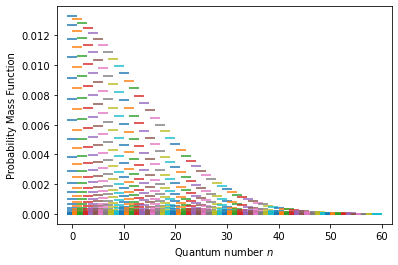

In [33]:
#! /usr/bin/env python

### recursive method: computes zeros ranges of Jn(r,n) from zeros of Jn(r,n-1)
### (also for zeros of (rJn(r,n))')
### pros : you are certain to find the right zeros values;
### cons : all zeros of the n-1 previous Jn have to be computed;
### note : Jn(r,0) = sin(r)/r

from scipy.special import jv, jvp
from scipy.optimize import brentq
import matplotlib.pyplot as plt

def Jn(r,n):
  return (np.sqrt(np.pi/(2*r))*jv(n+0.5,r))
def Jn_zeros(n,nt):
  zerosj = np.zeros((n+1, nt), dtype=np.float32)
  zerosj[0] = np.arange(1,nt+1)*np.pi
  points = np.arange(1,nt+n+1)*np.pi
  racines = np.zeros(nt+n, dtype=np.float32)
  for i in range(1,n+1):
    for j in range(nt+n-i):
      foo = brentq(Jn, points[j], points[j+1], (i,))
      racines[j] = foo
    points = racines
    zerosj[i][:nt] = racines[:nt]
  return (zerosj)
def rJnp(r,n):
  return (0.5*np.sqrt(np.pi/(2*r))*jv(n+0.5,r) + np.sqrt(np.pi*r/2)*jvp(n+0.5,r))
def rJnp_zeros(n,nt):
  zerosj = np.zeros((n+1, nt), dtype=np.float32)
  zerosj[0] = (2.*np.arange(1,nt+1)-1)*np.pi/2
  points = (2.*np.arange(1,nt+n+1)-1)*np.pi/2
  racines = np.zeros(nt+n, dtype=np.float32)
  for i in range(1,n+1):
    for j in range(nt+n-i):
      foo = brentq(rJnp, points[j], points[j+1], (i,))
      racines[j] = foo
    points = racines
    zerosj[i][:nt] = racines[:nt]
  return (zerosj)

num_zeros = 100
num_zeros = 120
ns = np.arange(0,120)  # n'th spherical bessel function
nt = num_zeros # number of zeros to be computed

dr = 0.01
eps = dr/1000

Q = 0
Eavg = 0
for n in ns:
    jnz = Jn_zeros(n,nt)[n]
    r1 = np.arange(eps,jnz[len(jnz)-1],dr)
    jnzp = rJnp_zeros(n,nt)[n]
    r2 = np.arange(eps,jnzp[len(jnzp)-1],dr)

    #plt.plot(r1,Jn(r1,n))
    #plt.scatter(jnz,np.zeros(len(jnz)), jnzp,np.zeros(len(jnzp)),marker='|')
    
    #plt.scatter(jnz,np.zeros(len(jnz))+n,marker='|', s=100)
    #plt.scatter(np.zeros(len(jnz))+n,E(jnz,m,a,b),marker='_', s=50)
    Enz = E(jnz,m,a,b)
    pz = np.exp(-beta*Enz)
    Eavg += np.dot(Enz, pz)
    Q += np.sum(pz)
    if n == ns[0]:
        print("ZPE = {} kcal/mol".format(Enz[0] * HARTREE2KCALMOL))
        print(np.min(Enz)*HARTREE2KCALMOL)
    if n == ns[-2] or n == ns[-1]:
        print(Q)
    #plt.scatter(np.zeros(len(jnz))+n, pz, marker='_', s=100)
Eavg /= Q
F = -np.power(beta, -1)*np.log(Q)
S = (Eavg-F)/T
# plotting
for n in ns[:60]:
    jnz = Jn_zeros(n,nt)[n]
    r1 = np.arange(eps,jnz[len(jnz)-1],dr)
    jnzp = rJnp_zeros(n,nt)[n]
    r2 = np.arange(eps,jnzp[len(jnzp)-1],dr)
    pz = np.exp(-beta*E(jnz,m,a,b))
    plt.scatter(np.zeros(len(jnz))+n, pz/Q, marker='_', s=100)
    plt.xlabel('Quantum number $n$')
    plt.ylabel('Probability Mass Function')
#plt.plot([Eavg, Eavg], [0, 60], 'k')

In [34]:
# particle in spherical cavity

print('U = {} kcal/mol'.format(Eavg*HARTREE2KCALMOL),
      'S = {} cal/mol.K'.format(S*HARTREE2KCALMOL*1000))
print(jv, a)

U = 0.6146649635788537 kcal/mol S = 10.616716026469653 cal/mol.K
<ufunc 'jv'> 3.7


ZPE = 0.005376806800529916 kcal/mol
77.58104070038901
77.58104071361569
U = 0.6005630888947727 kcal/mol S = 10.66106181027062 cal/mol.K
0.29814999999999997


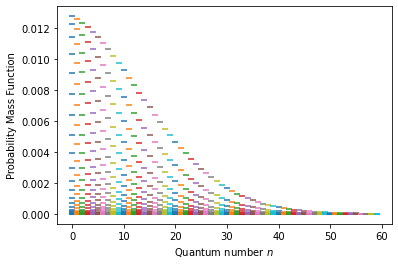

In [16]:
# TRANSLATIONAL ENERGY LEVELS FROM PIB
### particle in a cylindrical cavity
a = 3.7 # Angstrom
from scipy.special import jn_zeros
import matplotlib.pyplot as plt
#r = np.linspace(0,7*np.pi,500)
num_zeros = 100
n = np.arange(0,100)

Q = 0
Eavg = 0
for ni in n:
    zn = jn_zeros(ni, num_zeros)
    Enl = E(zn, m, a, b)
    pz = np.exp(-beta*Enl)
    Eavg += np.dot(Enl, pz)
    Q += np.sum(pz)
    if ni == n[0]:
        print("ZPE = {} kcal/mol".format(Enl[0] * HARTREE2KCALMOL))
    if ni == n[-2] or ni == n[-1]:
        print(Q)
Eavg /= Q
F = -np.power(beta, -1)*np.log(Q)
S = (Eavg-F)/T

for ni in n[:60]:
    zn = jn_zeros(ni, num_zeros)
    Enl = E(zn, m, a, b)
    plt.scatter(np.zeros(len(zn)) + ni, np.exp(-beta*Enl)/Q, marker='_')
    plt.xlabel('Quantum number $n$')
    plt.ylabel('Probability Mass Function')
    #plt.plot(r, spherical_jn(ni,r))
print('U = {} kcal/mol'.format(Eavg*HARTREE2KCALMOL),
      'S = {} cal/mol.K'.format(S*HARTREE2KCALMOL*1000))
print(0.5*0.002*298.15)

In [137]:
def Phi(m, x):
    """ Sine and cosine complex components """
    if m > 0:
        return np.sqrt(2)*np.cos(m*x);
    elif m == 0:
        return 1;
    else:
        return np.sqrt(2)*np.sin(np.abs(m)*x);

def D(el, m, mp, phi, theta, chi):
    """ Real Wigner D Matrix """
    return np.sign(mp) * Phi(m, phi)*Phi(mp, chi) *\
        0.5*(d(el, np.abs(mp), np.abs(m), theta) + np.power(-1, m)*d(el, np.abs(m), -np.abs(mp), theta)) -\
             np.sign(m) * Phi(-m, phi)*Phi(-mp, chi) *\
             0.5*(d(el, np.abs(mp), np.abs(m), theta) - np.power(-1, m)*d(el, np.abs(m), -np.abs(mp), theta))

In [138]:
for pt,vpt in zip(pts,vpts):
    print(*pt, vpt)

0.4111378623223478 0.7853981633974483 0.0 0.0
0.4111378623223478 0.7853981633974483 0.5235987755982988 0.001564239999424899
0.4111378623223478 0.7853981633974483 1.0471975511965976 0.0022551500023837434
0.4111378623223478 0.7853981633974483 1.5707963267948966 0.0038429000014730264
0.4111378623223478 0.7853981633974483 2.0943951023931953 0.0035356700009288033
0.4111378623223478 0.7853981633974483 2.617993877991494 0.001590240000950871
0.4111378623223478 0.7853981633974483 3.141592653589793 0.0007134900006349199
0.4111378623223478 0.7853981633974483 3.665191429188092 0.001541969999379944
0.4111378623223478 0.7853981633974483 4.1887902047863905 0.0015717799997219117
0.4111378623223478 0.7853981633974483 4.71238898038469 0.0009372999993502162
0.4111378623223478 0.7853981633974483 5.235987755982988 0.00042536000000836793
0.4111378623223478 0.7853981633974483 5.759586531581287 0.0007585700004710816
0.4111378623223478 2.356194490192345 0.0 0.0011162000009790063
0.4111378623223478 2.3561944901

2.300523983021863 5.105088062083414 3.141592653589793 0.0018582499997137347
2.300523983021863 5.105088062083414 3.665191429188092 0.0019549300013750326
2.300523983021863 5.105088062083414 4.1887902047863905 0.0017316300018137554
2.300523983021863 5.105088062083414 4.71238898038469 0.001494000000093365
2.300523983021863 5.105088062083414 5.235987755982988 0.002011390002735425
2.300523983021863 5.105088062083414 5.759586531581287 0.0018245200008095708
2.300523983021863 5.890486225480861 0.0 0.002287389999764855
2.300523983021863 5.890486225480861 0.5235987755982988 0.002669110001079389
2.300523983021863 5.890486225480861 1.0471975511965976 0.005429580000054557
2.300523983021863 5.890486225480861 1.5707963267948966 0.005368640000597225
2.300523983021863 5.890486225480861 2.0943951023931953 0.004622780001227511
2.300523983021863 5.890486225480861 2.617993877991494 0.0036328500009403797
2.300523983021863 5.890486225480861 3.141592653589793 0.002849390000847052
2.300523983021863 5.8904862254

In [139]:
# Real Wigner D Matrices
# f(φ,θ,χ) is parameterized by Euler angles
converged = False;
while (not converged):
    print("not converged");
    converged = True;

not converged


In [140]:
# PLOT SHOWING NUMBER OF SAMPLES REQUIRED FOR LEBEDEV
for npts in [6, 14, 26, 38, 50, 74, 86, 110, 146, 170]:
    resol = 2*np.sqrt(np.pi/npts)
    nchi = len(np.linspace(0,2*np.pi, int(np.floor(2*np.pi/resol)))[:-1])
    print(npts, ':', npts*nchi, ':', np.around(resol*180/np.pi, 3), 'degrees')

6 : 18 : 82.919 degrees
14 : 70 : 54.283 degrees
26 : 208 : 39.833 degrees
38 : 342 : 32.949 degrees
50 : 550 : 28.724 degrees
74 : 1036 : 23.611 degrees
86 : 1290 : 21.902 degrees
110 : 1870 : 19.366 degrees
146 : 2920 : 16.809 degrees
170 : 3740 : 15.578 degrees


In [141]:
# GET SORTED SPHERICAL GRIDPOINTS
xyz,wts = numgrid.angular_grid(50)
XYZ = np.array([np.array(coord) for coord in xyz])
X,Y,Z = XYZ[:,0], XYZ[:,1], XYZ[:,2]
theta,phi = np.arctan2(np.sqrt(np.power(X,2)+np.power(Y,2)),Z), np.arctan2(Y,X)%(2*np.pi)
angs = np.array(list(sorted(zip(theta,phi), key=lambda t: t[0])))

ind = np.lexsort((angs[:,1], angs[:,0]))
angs = np.array([np.array([angs[i,0], angs[i,1]]) for i in ind])

for ang in angs:
    print(*ang)

0.0 0.0
0.4405106630046983 0.7853981633974482
0.4405106630046983 2.356194490192345
0.4405106630046983 3.9269908169872414
0.4405106630046983 5.497787143782138
0.7853981633974483 0.0
0.7853981633974483 1.5707963267948966
0.7853981633974483 3.141592653589793
0.7853981633974483 4.71238898038469
0.9553166181245092 0.7853981633974482
0.9553166181245092 2.356194490192345
0.9553166181245092 3.9269908169872414
0.9553166181245092 5.497787143782138
1.2645189576252271 0.3217505543966423
1.2645189576252271 1.2490457723982544
1.2645189576252271 1.8925468811915387
1.2645189576252271 2.819842099193151
1.2645189576252271 3.4633432079864352
1.2645189576252271 4.3906384259880475
1.2645189576252271 5.034139534781332
1.2645189576252271 5.961434752782944
1.5707963267948966 0.0
1.5707963267948966 0.7853981633974483
1.5707963267948966 1.5707963267948966
1.5707963267948966 2.356194490192345
1.5707963267948966 3.141592653589793
1.5707963267948966 3.9269908169872414
1.5707963267948966 4.71238898038469
1.57079632

1.0 10.0 35.0 83.99999999999999 164.99999999999997 286.0 454.99999999999994 680.0 969.0 1330.0 1771.0 2300.0 2925.0 3653.9999999999995 4495.0 5455.999999999999 6544.999999999999 7770.0 9139.0 10660.0 12341.0 14190.0 16215.0 18424.0 20824.999999999996 23425.999999999996 26235.0 29259.999999999996 32509.0 35990.0 39710.99999999999 43680.0 47905.0 52393.99999999999 57155.0 62196.0 67525.0 73150.0 79079.0 85320.0 91881.0 98770.0 105995.0 113564.0 121485.0 129766.0 138415.0 147440.0 156849.0 166649.99999999997


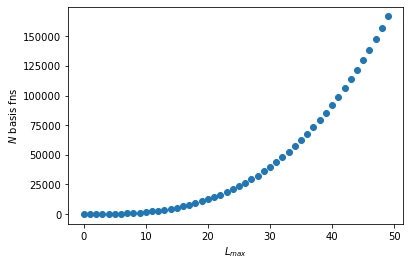

In [142]:
lmax = np.arange(0,50)
size = ((1.0/3.0)*(lmax+1)*(2*lmax+1)*(2*lmax+3));
print(*size)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('$N$ basis fns')
ax.set_xlabel('$L_{max}$')
ax.scatter(lmax,size,marker='o')